## Введение
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

### Задача:

1. Проверить Был ли эксперимент успешен в целом.

2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*


## Данные 

### users_*.csv – информация о пользователях

uid – идентификатор пользователя

age – возраст

attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры *1000)

coins – число монеток (внутренняя валюта)

country – страна  

visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

gender – пол

age_filter_start  – фильтр поиска, мин. значение 

age_filter_end  – фильтр поиска, макс. значение 

views_count – число полученных оценок 

was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)

is_premium –  является ли премиум

total_revenue – нормированная выручка


### transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя

country – страна

joined_at – дата и время регистрации

paid_at – дата и время покупки

revenue – нормированная выручка

payment_id – идентификатор платежа

from_page – откуда пользователь перешел на страницу оплаты

product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за 
внутреннюю валюту, other_type – другое)


### Файлы:

users_test – информация о пользователях в тестовой группе. 

users_control_1 – информация о пользователях в первой контрольной группе. 

users_control_2 – информация о пользователях во второй контрольной группе . 

transactions_test – информация о платежах пользователей в тестовой группе. 

transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 

transactions_control_2 – информация о платежах пользователей во второй контрольной группе 
  



In [186]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import datetime

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
from scipy import stats
import plotly.express as px


# Преобразуем данные

In [187]:
def processing_a_data(df):
   df.fillna('0', inplace=True)
   df['visit_days'] = df['visit_days'].apply (lambda x : [int(i) for i in x.replace('.',',').split(',') ] )
   df['count_of_visit_days'] = df['visit_days'].apply (lambda x : len(x) if x[0]!=0 else 0)
   df[['was_premium','is_premium','coins']] = df[['was_premium','is_premium','coins']].astype(int)
   lst_col = ['uid', 'age', 'attraction_coeff', 'coins', 'country', 'visit_days', 'count_of_visit_days',
   'gender', 'age_filter_start', 'age_filter_end', 'views_count',
   'was_premium', 'is_premium', 'total_revenue']
   return df[lst_col] 




In [188]:
users_test = pd.read_csv('./users_test.csv',sep = ';') 
users_test = processing_a_data(users_test)
users_test.uid.nunique()

4308

In [189]:
users_control_1 = pd.read_csv('./users_control_1.csv', sep = ';')
users_control_1 = processing_a_data(users_control_1)
users_control_1.uid.nunique()

4340

In [190]:
users_control_2 = pd.read_csv('./users_control_2.csv', sep = ';')
users_control_2 = processing_a_data(users_control_2)
users_control_2.uid.nunique()

4264

In [191]:
transactions_test = pd.read_csv('./transactions_test.csv',sep=';')

transactions_test[['joined_at', 'paid_at']] = transactions_test[['joined_at', 'paid_at']].apply (pd.to_datetime)
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [192]:
# Видим,что в данной таблицы много пропущенных значений. Также некоторые столбцы имеют не правельный тип данных.
transactions_control_1 = pd.read_csv('./transactions_control_1.csv', sep=';')
transactions_control_1.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [193]:
transactions_control_1.dropna(inplace=True)
transactions_control_1[['joined_at', 'paid_at']] = transactions_control_1[['joined_at', 'paid_at']].apply (pd.to_datetime)
transactions_control_1[['uid','revenue','payment_id']] = transactions_control_1[['uid','revenue','payment_id']].astype(int)
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    int64         
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    int64         
 5   payment_id    377 non-null    int64         
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 26.5+ KB


In [194]:
transactions_control_2 = pd.read_csv('./transactions_control_2.csv',sep=';')
transactions_control_2[['joined_at', 'paid_at']] = transactions_control_2[['joined_at', 'paid_at']].apply (pd.to_datetime)
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [195]:
df = transactions_test[transactions_test['product_type'] == 'premium_no_trial']

df_1 = transactions_control_1[transactions_control_1['product_type'] == 'premium_no_trial']

df_2 = transactions_control_2[transactions_control_2['product_type'] == 'premium_no_trial']


Text(0.5, 1.0, 'Control_2')

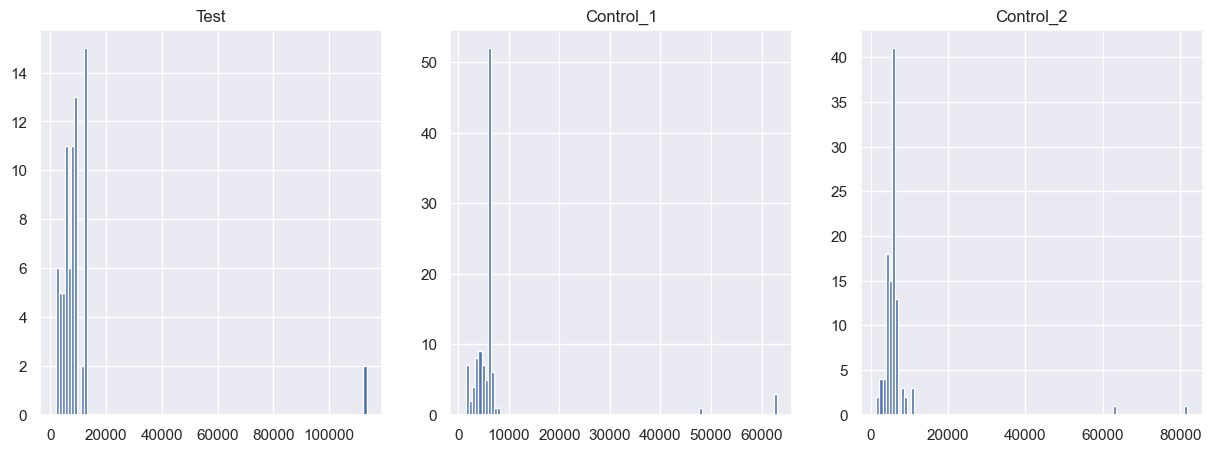

In [196]:
# Построим графики распределения
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].hist(df.revenue, bins= 100)
ax[0].set_title('Test')
ax[1].hist(df_1.revenue, bins= 100)
ax[1].set_title('Control_1')
ax[2].hist(df_2.revenue, bins= 100)
ax[2].set_title('Control_2')

Видим явыне выбросы.

In [197]:
# Исключаем всё, что за 95 квантилем
df = df[df['revenue'] <= df.revenue.quantile(0.95)]
df_1 = df_1[df_1['revenue'] <= df_1.revenue.quantile(0.95)]
df_2 = df_2[df_2['revenue'] <= df_2.revenue.quantile(0.95)]
print('Сред. revenue Test:',df.revenue.mean())
print('Сред. revenue Control_1:',df_1.revenue.mean())
print('Сред. revenue COntrol_2:',df_2.revenue.mean())

Сред. revenue Test: 7888.540540540541
Сред. revenue Control_1: 5271.63
Сред. revenue COntrol_2: 5536.455445544554


Text(0.5, 1.0, 'Control_2')

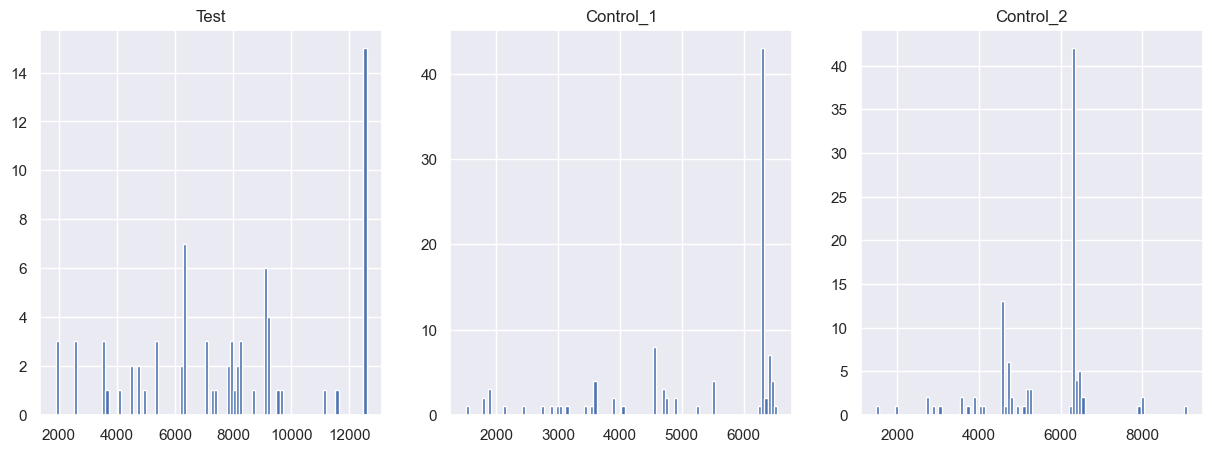

In [198]:
# Построим график расспределения отбросив выбрасы в данных. 
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].hist(df.revenue, bins= 100)
ax[0].set_title('Test')
ax[1].hist(df_1.revenue, bins= 100)
ax[1].set_title('Control_1')
ax[2].hist(df_2.revenue, bins= 100)
ax[2].set_title('Control_2')

# Проводим А/А тест на двух контрольных группах о транзакциях. 

  0%|          | 0/10000 [00:00<?, ?it/s]

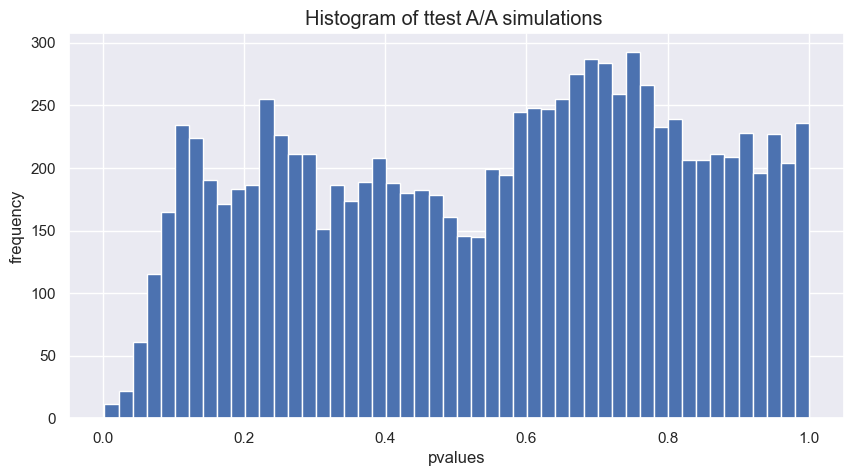

0.0046

In [199]:
con_1 = transactions_control_1[transactions_control_1['product_type'] == 'premium_no_trial']
con_2 = transactions_control_2[transactions_control_2['product_type'] == 'premium_no_trial']
n_s = 50
simulations = 10000
res = []


for i in tqdm(range(simulations)):
    s1 = con_1['revenue'].sample(n_s, replace = False).values
    s2 = con_2['revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

В результате, делаем вывод, что система сплитования качественная.


# Посмотрим на показатели метрики ARPU в рамках тестируемого продукта (premium_no_trial) за общее количество пользователей берем количество уникальных пользователей в группе

In [200]:
ARPU_test = df.revenue.sum() / users_test.uid.nunique() 

ARPU_control_1 = df_1.revenue.sum() / users_control_1.uid.nunique() 

ARPU_control_2 = df_2.revenue.sum() / users_control_2.uid.nunique() 

print(f'ARPU_test: {ARPU_test}', f'ARPU_control_1: {ARPU_control_1}', f'ARPU_control_2: {ARPU_control_2}', sep='\n')



ARPU_test: 135.5041782729805
ARPU_control_1: 121.46612903225807
ARPU_control_2: 131.140243902439


In [201]:
# Также смотрим на ARPPU 
ARPPU_test = round(df.revenue.sum() / df.uid.nunique(), 2) 

ARPPU_control_1 = round(df_1.revenue.sum() / df_1.uid.nunique(), 2)

ARPPU_control_2 = round(df_2.revenue.sum() / df_2.uid.nunique(), 2 )

print(f'ARPPU_test: {ARPPU_test}', f'ARPPU_control_1: {ARPPU_control_1}', f'ARPPU_control_2: {ARPPU_control_2}', sep='\n')

ARPPU_test: 8980.8
ARPPU_control_1: 5668.42
ARPPU_control_2: 5824.81


In [202]:
# Смотрим на конверсию с целевым действием, был ли когда-либо премиум и имеют ли премиум .
CR_test_1 = users_test.groupby('was_premium',as_index=False).agg({'uid':'count'}).uid[1] / users_test.groupby('was_premium',as_index=False).agg({'uid':'count'}).uid[0]
print('users_test')
print(f'Имели когда-либо премиум {round(CR_test_1,3)*100}%')
CR_test_2 = users_test.groupby('is_premium',as_index=False).agg({'uid':'count'}).uid[1] / users_test.groupby('is_premium',as_index=False).agg({'uid':'count'}).uid[0]
print(f'Имеют премиум сейчас {round(CR_test_2,3)*100}%')

users_test
Имели когда-либо премиум 10.5%
Имеют премиум сейчас 3.8%


In [203]:
CR_control_1 = users_control_1.groupby('was_premium',as_index=False).agg({'uid':'count'}).uid[1] / users_control_1.groupby('was_premium',as_index=False).agg({'uid':'count'}).uid[0]
print('users_control_1')
print(f'Имели когда-либо премиум { round(CR_control_1, 4)*100 }%')
CR_control_2 = users_control_1.groupby('is_premium',as_index=False).agg({'uid':'count'}).uid[1] / users_control_1.groupby('is_premium',as_index=False).agg({'uid':'count'}).uid[0]
print(f'Имеют премиум сейчас { round(CR_control_2,3)*100 }% ')

users_control_1
Имели когда-либо премиум 11.17%
Имеют премиум сейчас 4.6% 


In [204]:
CR_control2_1 = users_control_2.groupby('was_premium',as_index=False).agg({'uid':'count'}).uid[1] / users_control_2.groupby('was_premium',as_index=False).agg({'uid':'count'}).uid[0]
print('users_control_2')
print(f'Имели когда-либо премиум { round(CR_control2_1, 4)*100 }%')
CR_control2_2 = users_control_2.groupby('is_premium',as_index=False).agg({'uid':'count'}).uid[1] / users_control_2.groupby('is_premium',as_index=False).agg({'uid':'count'}).uid[0]
print(f'Имеют премиум сейчас { round(CR_control2_2,3)*100 }% ')

users_control_2
Имели когда-либо премиум 10.67%
Имеют премиум сейчас 4.7% 


Видим разницу значений в метриках между тестовыми и контрольными группами.


# Проверим, являются ли эти различия статистически значимыми с помощью теста mannwhitneyu.

т.к. данные распределены не соответсвуют нормальному, а группы независимые.

In [205]:
stat, p = mannwhitneyu(df.revenue, df_1.revenue)
print(f'Statistics={stat}, p={p}')
#Получаем статистически значимое различие между группами test и control_1


Statistics=5574.5, p=8.013036491837227e-09


In [206]:
stat, p = mannwhitneyu(df.revenue, df_2.revenue)
print(f'Statistics={stat}, p={p}')
#Также получаем статистически значимое различие между группами test и control_2


Statistics=5487.0, p=9.646310717539622e-08


In [207]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('default')
    plt.vlines(ci,ymin=20, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

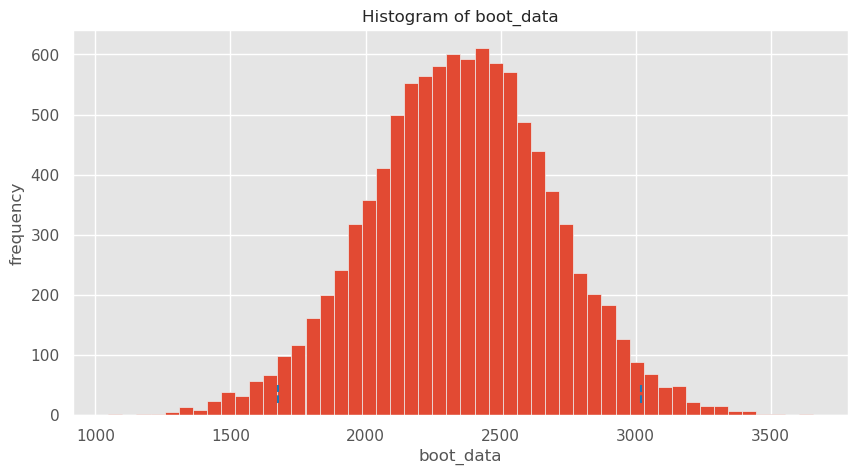

In [208]:
booted_data = get_bootstrap(df.revenue,df_2.revenue, boot_it = 10000,statistic = np.mean) 

In [209]:
# По итогу получаем значение p уровня ниже нашей границы в 0.05
booted_data["p_value"]

4.656727239149432e-12

In [210]:
# 0 не входит в полученный доверительный интервал, что свидетельствует о статистически значимом различии нашей статистики(средней выручки на группу) в данных группах. 
booted_data["ci"]

,0
0.025,1674.551238
0.975,3018.448762


Мы видим, что в тествой группе конверсии с целевым действием "пользователь имеет премиум подписку" значительно ниже, чем в контрольных группах. Но при этом среднее revenue в тестовой группе значительно выше контрольных. ARPPU в тестовой группе также имеет большее значение. 
Можем предположить, что наше нововведение положительно повлияло на пользователей, которые уже имеют подписку, и увеличение доходов связанно именно с этой группой пользователей. Также, есть предположение, что чаще стали покупать подписку на больший период.   

# Посмотрим какой эффект нововведения оказало на разные подгруппы пользователей в тестовой и контрольных выборках


In [211]:
# Разобьем на возрастные группы
cut_bins = [0,20,30,40,np.inf]
cut_labels = ['0-20','20-30','30-40','40-inf']

In [212]:
merge_data = pd.merge(users_test, 
                      transactions_test.groupby(['uid', 'product_type'],as_index=False).agg({'revenue':'sum'}),
                      on='uid',
                      how='outer',
                      ).dropna()

merge_data['age_groupe'] = pd.cut(merge_data['age'],bins=cut_bins, labels=cut_labels)

ax_test = merge_data.query('product_type =="premium_no_trial"').groupby('age_groupe',as_index=False).agg({'revenue':'sum',
                                                                                                          'uid':'count'})

merge_data_1 = pd.merge(users_control_1, 
                      transactions_control_1.groupby(['uid', 'product_type'],as_index=False).agg({'revenue':'sum'}),
                      on='uid',
                      how='outer',
                      ).dropna()
merge_data_1['age_groupe'] =  pd.cut(merge_data_1['age'],bins=cut_bins, labels=cut_labels)

ax_1 = merge_data_1.query('product_type =="premium_no_trial"').sample(len(merge_data.query('product_type =="premium_no_trial"')),random_state=34).groupby('age_groupe',as_index=False).agg({'revenue':'sum'})

merge_data_2 = pd.merge(users_control_2, 
                      transactions_control_2.groupby(['uid', 'product_type'],as_index=False).agg({'revenue':'sum'}),
                      on='uid',
                      how='outer',
                      ).dropna()
merge_data_2['age_groupe'] =  pd.cut(merge_data_2['age'],bins=cut_bins, labels=cut_labels)
sns.set(rc={'figure.figsize':(10,5)})
ax_2 = merge_data_2.query('product_type =="premium_no_trial"').sample(len(merge_data.query('product_type =="premium_no_trial"')),random_state=34).groupby('age_groupe',as_index=False).agg({'revenue':'sum'})

Text(0.5, 1.0, 'Control_2')

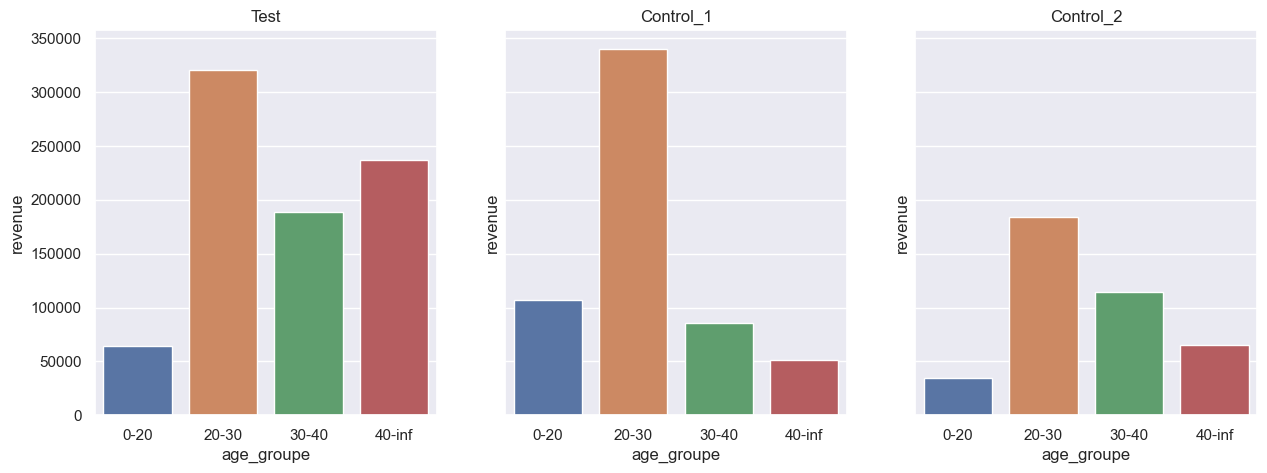

In [213]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('')

# Bulbasaur
sns.barplot(ax=axes[0], x=ax_test.age_groupe, y=ax_test.revenue)
axes[0].set_title('Test')

# Charmander
sns.barplot(ax=axes[1], x= ax_1.age_groupe, y= ax_1.revenue)
axes[1].set_title('Control_1')

# Squirtle
sns.barplot(ax=axes[2], x= ax_2.age_groupe, y= ax_2.revenue)
axes[2].set_title('Control_2')

Получаем значительное увеличение доходов в группах от 30-40 и от 40 лет. Но при это снижение доходов в группе 20-30 лет. 

In [214]:

merge_data.query('product_type =="premium_no_trial"').groupby('age_groupe',as_index=False).agg({'revenue':'count'})

,age_groupe,revenue
0,0-20,6
1,20-30,24
2,30-40,24
3,40-inf,13


In [215]:
merge_data_1.query('product_type =="premium_no_trial"').sample(len(merge_data.query('product_type =="premium_no_trial"')),random_state=34).groupby('age_groupe',as_index=False).agg({'revenue':'count'})

,age_groupe,revenue
0,0-20,7
1,20-30,35
2,30-40,16
3,40-inf,9


In [216]:
merge_data_2.query('product_type =="premium_no_trial"').sample(len(merge_data.query('product_type =="premium_no_trial"')),random_state=34).groupby('age_groupe',as_index=False).agg({'revenue':'count'})

,age_groupe,revenue
0,0-20,5
1,20-30,35
2,30-40,17
3,40-inf,10


Посмотрим на распределения доходов, в групах по attraction_coeff

In [217]:
cut_bins = [0,250,500,750,np.inf]
cut_labels = ['0-250','250-500','500-750','750-1000']
merge_data['attraction_g'] = pd.cut(merge_data['attraction_coeff'],bins=cut_bins, labels=cut_labels)
merge_data_1['attraction_g'] = pd.cut(merge_data_1['attraction_coeff'],bins=cut_bins, labels=cut_labels)
merge_data_2['attraction_g'] = pd.cut(merge_data_2['attraction_coeff'],bins=cut_bins, labels=cut_labels)
ax_test = merge_data.query('product_type =="premium_no_trial"').groupby('attraction_g',as_index=False).agg({'revenue':'sum'})
ax_1 = merge_data_1.query('product_type =="premium_no_trial"').sample(len(merge_data.query('product_type =="premium_no_trial"')),random_state=34).groupby('attraction_g',as_index=False).agg({'revenue':'sum'})
ax_2 = merge_data_2.query('product_type =="premium_no_trial"').sample(len(merge_data.query('product_type =="premium_no_trial"')),random_state=34).groupby('attraction_g',as_index=False).agg({'revenue':'sum'})

Text(0.5, 1.0, 'Control_2')

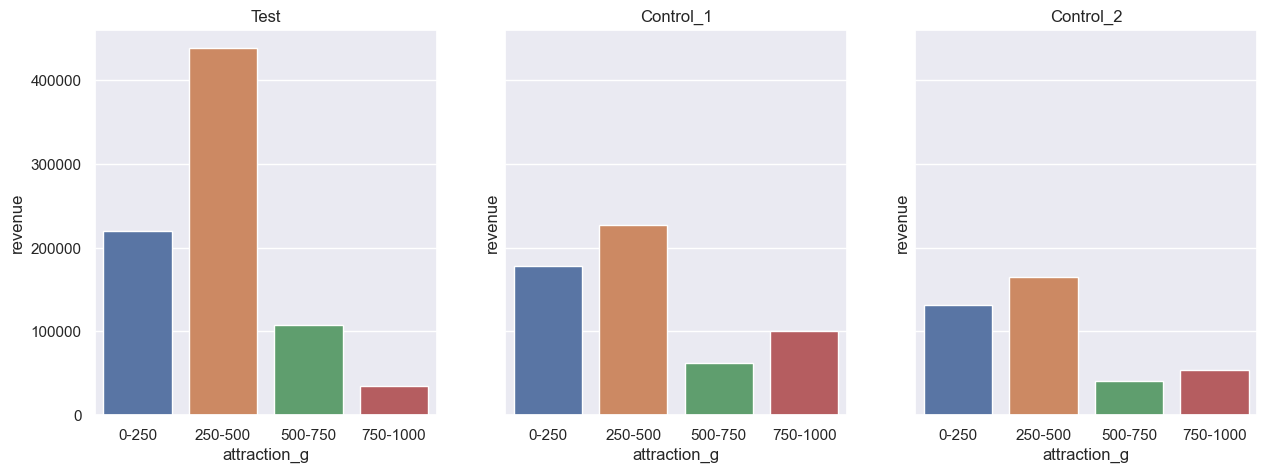

In [218]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('')

# Bulbasaur
sns.barplot(ax=axes[0], x=ax_test.attraction_g, y=ax_test.revenue)
axes[0].set_title('Test')

# Charmander
sns.barplot(ax=axes[1], x= ax_1.attraction_g, y= ax_1.revenue)
axes[1].set_title('Control_1')

# Squirtle
sns.barplot(ax=axes[2], x= ax_2.attraction_g, y= ax_2.revenue)
axes[2].set_title('Control_2')

In [219]:
merge_data.query('product_type =="premium_no_trial"').groupby('attraction_g',as_index=False).agg({'revenue':'count'})

,attraction_g,revenue
0,0-250,23
1,250-500,26
2,500-750,12
3,750-1000,4


In [220]:
merge_data_1.query('product_type =="premium_no_trial"').groupby('attraction_g',as_index=False).agg({'revenue':'count'})

,attraction_g,revenue
0,0-250,30
1,250-500,38
2,500-750,14
3,750-1000,10


In [221]:
merge_data_2.query('product_type =="premium_no_trial"').groupby('attraction_g',as_index=False).agg({'revenue':'count'})

,attraction_g,revenue
0,0-250,33
1,250-500,39
2,500-750,15
3,750-1000,9


In [222]:
merge_data_1.query('product_type =="premium_no_trial"').pivot_table(index='attraction_g',columns='age_groupe',values='uid',aggfunc='count')

age_groupe,0-20,20-30,30-40,40-inf
attraction_g,,,,
0-250,2,16,8,4
250-500,3,20,8,7
500-750,1,7,3,3
750-1000,2,6,1,1


In [223]:
merge_data_2.query('product_type =="premium_no_trial"').pivot_table(index='attraction_g',columns='age_groupe',values='uid',aggfunc='count')

age_groupe,0-20,20-30,30-40,40-inf
attraction_g,,,,
0-250,5,13,9,6
250-500,2,24,9,4
500-750,2,6,5,2
750-1000,1,7,0,1


In [224]:
bx = merge_data.query('product_type =="premium_no_trial"').groupby(['age_groupe','attraction_g']).agg({'revenue':'sum'})
bx.reset_index(inplace=True)
bx['group'] = 'test'
by = merge_data_1.query('product_type =="premium_no_trial"').groupby(['age_groupe','attraction_g']).agg({'revenue':'sum'})
by['group'] = 'control_1'
by.reset_index(inplace=True)
bv = merge_data_2.query('product_type =="premium_no_trial"').groupby(['age_groupe','attraction_g']).agg({'revenue':'sum'})
bv['group'] = 'control_2'
bv.reset_index(inplace=True)
bz = pd.concat([bx,by,bv], ignore_index=True )
bz.head()

,age_groupe,attraction_g,revenue,group
0,0-20,0-250,48945.0,test
1,0-20,250-500,9100.0,test
2,0-20,500-750,0.0,test
3,0-20,750-1000,0.0,test
4,20-30,0-250,55562.0,test


In [225]:
px.bar(bz, x="age_groupe", y="revenue", color="attraction_g", barmode="group", facet_col="group")


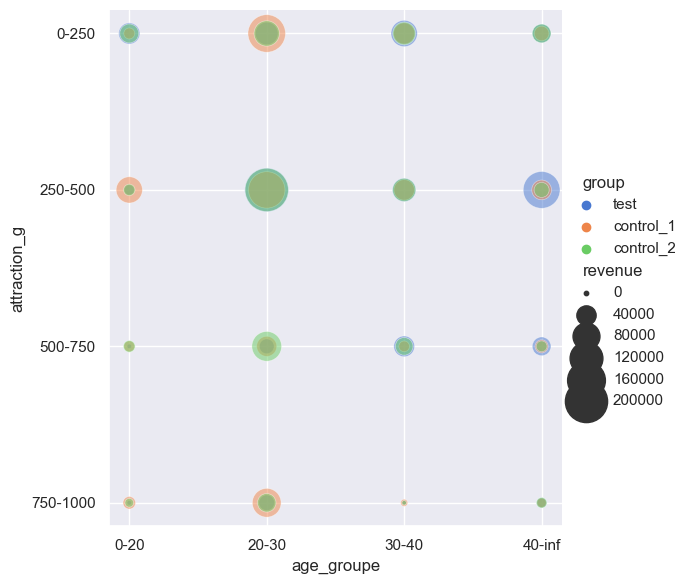

In [226]:

sns.relplot(x='age_groupe', y="attraction_g",hue= 'group', size="revenue",
            sizes=(10, 1000), alpha=.5, palette="muted",
            height=6, 
            data=bz)